# Setting up the case study
- Defining a price profile
- Plotting the price profile
- 

In [1]:
# import statements
from src.model_configuration import ModelConfiguration
import src.data_management as dm
from src.energyhub import EnergyHub
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Save Data File to file
data_save_path = Path('./user_data/data_handle_test')

The following piece of code shows the system topology, i.e., which technologies are part of the system and what is the time horizon. To assess the Ocean Battery technology as a stand-alone technology connected to the grid, the system consists solely of this technology. The time horizon is set for one week. 

Insert figure of difference specific and general model: show what is determined per slot and what for the whole tech?

In [2]:
# TOPOLOGY
topology = dm.SystemTopology()
topology.define_time_horizon(year=2001,start_date='01-01 00:00', end_date='01-07 00:00', resolution=1)
topology.define_carriers(['electricity'])
topology.define_nodes(['onshore'])
topology.define_new_technologies('onshore', ['Storage_OceanBattery_specific_2'])

# Initialize instance of DataHandle
data = dm.DataHandle(topology)

Then, we import all data needed for the scenario. This consists of the climate data (even though the technology is not related to climate data this is needed for the model to run) as well as import and export data. For the latter, price profiles of 2019 (day-ahead prices of NL bidding zone) are used (same profile for both import and export). 

In [3]:
# CLIMATE DATA
from_file = 1
if from_file == 1:
    data.read_climate_data_from_file('onshore', './data/climate_data_onshore.txt')

# IMPORT & EXPORT LIMITS
el_import = np.ones(len(topology.timesteps)) * 100
data.read_import_limit_data('onshore', 'electricity', el_import)

el_export = np.ones(len(topology.timesteps)) * 100
data.read_export_limit_data('onshore', 'electricity', el_export)

# IMPORT & EXPORT PRICES

el_price_profile_2019 = pd.read_csv(".\ob_input_data\day_ahead_2019.csv", header=0)
el_price_profile_2019 = np.array(el_price_profile_2019.iloc[:, 1])
el_price_profile_2019 = el_price_profile_2019[0:len(topology.timesteps)]

data.read_import_price_data('onshore', 'electricity', el_price_profile_2019)
data.read_export_price_data('onshore', 'electricity', el_price_profile_2019)

C:\Users\6145795\Documents\GitHub\EHUB-Py\src\data_management\utilities.py:159: UserWarning: Time series is longer than chosen time horizon - taking only the first couple of time slices
  warnings.warn('Time series is longer than chosen time horizon - taking only the first ' + \


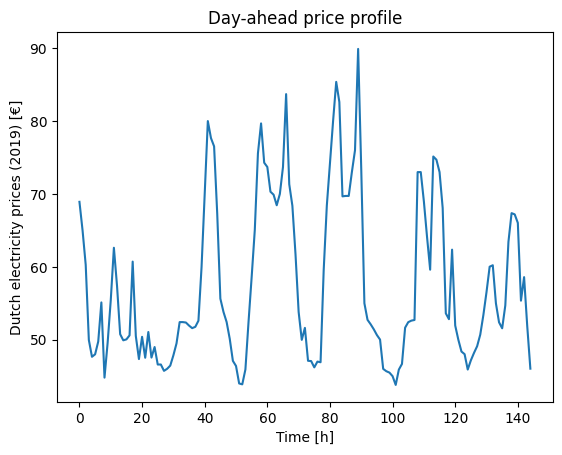

In [4]:
plt.plot(el_price_profile_2019)
plt.xlabel('Time [h]')
plt.ylabel('Electricity price [€/MWh]')
plt.title('Day-ahead price profile (NL; 2019)')
plt.show()

# Model and results
After the data is put in, the model is solved.

In [5]:
# READ TECHNOLOGY AND NETWORK DATA
data.read_technology_data()
data.read_network_data()

# SAVING/LOADING DATA FILE
configuration = ModelConfiguration()

# Read data
energyhub = EnergyHub(data, configuration)
results = energyhub.quick_solve()

____________________________________________________________
Reading in data...
Reading in data completed in 0 s
____________________________________________________________
____________________________________________________________
Constructing Model...
____________________________________________________________
--- Adding Networks... ---
____________________________________________________________
--- Adding Node onshore... ---
	 - Adding Technology Storage_OceanBattery_specific_2
		Big-M Transformation...
		Big-M Transformation completed in 1 s
		Big-M Transformation...
		Big-M Transformation completed in 1 s
		Big-M Transformation...
		Big-M Transformation completed in 2 s
		Big-M Transformation...
		Big-M Transformation completed in 0 s
		Big-M Transformation...
		Big-M Transformation completed in 1 s
		Big-M Transformation...
		Big-M Transformation completed in 2 s
		Big-M Transformation...
		Big-M Transformation completed in 0 s
		Big-M Transformation...
		Big-M Transformatio

Design results: 
- Size of reservoir
- Pump size
- Turbine size
  
Plots of OB functioning:
- Hourly storage level/discharge/charge 

In [6]:
print('Reservoir size [m3]:' + b_tec.var_size.value)
print('Pump size [MW]:' + b_tec.var_size_single_pump.value)
print('Turbine size [MW]:' + b_tec.var_size_single_turbine.value)


# Pump_type? 

NameError: name 'b_tec' is not defined